# 12 - Ejercicio: Clasificación de Tweets en Español (Análisis de Sentimientos)

* En el siguiente ejercicio tiene como objetivo aplicar los conocimientos vistos hasta el momento de:
    - Normalización de textos (procesamiento de textos)
    - Clasificación de textos
    
    
* El ejercicio consiste en clasificar una serie de tweets en Español que estan clasificados como '***positivos***', '***neutros***', '***negativos***' o '***None***' (desconocido), aunque solo vamos a trabajar con los tweets clasificados correctamente (los no desconocidos).


* Para este ejercicio se pide realizar todo el proceso de clasificación visto hasta el momento:
    1. Carga de los datos (ya implementado en el ejercicio)
    2. Normalización de los tweets
    3. Creacción de la Bolsa de Palabras
    4. Particionado de Datos
    5. Creacción de modelos
    6. Evaluación de los modelos


* Los puntos del 2 al 6 son los que hay que realizar con los visto hasta el momento.

<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. 


* Estos datos estan en un archivo con extensión '*txt*' pero tienen estructura de '*csv*' y tienen como separador '***::::***'.


* Este fichero lo podemos leer como un '*csv*' con pandas, estructurándolo de la siguiente manera:
    - **Posición 0**: Tweet
    - **Posición 1**: Sentimiento (Positivo | Neutro | Negativo)
    
    
* Los tweets estan clasificados con 4 etiquetas, pero vamos a trabajar solo con los tweets que sean '***positivos***', '***neutros***' o '***negativos***'.

In [1]:
import pandas as pd
tweets_file = '../data/tweets_castellano.txt'
df = pd.read_csv(tweets_file, sep="::::", names=['tweet','sentimiento'] ,engine='python')
df = df[df['sentimiento'].isin(['positivo', 'neutro', 'negativo'])]
tweets = [tuple(x) for x in df.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))
df.head(5)

Número de Tweets Cargados: 5735


,tweet,sentimiento
1,@PauladeLasHeras No te libraras de ayudar me/n...,neutro
2,@marodriguezb Gracias MAR,positivo
3,"Off pensando en el regalito Sinde, la que se v...",negativo
4,Conozco a alguien q es adicto al drama! Ja ja ...,positivo
6,Toca @crackoviadeTV3 . Grabación dl especial N...,positivo


<hr>


## Normalización

* Para este ejercicio haremos uso de ***spaCy*** para la tokenización y normalización.


* Para ***normalizar*** los tweets realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las Stop-Words.
    5. Eliminamos los enlaces (vamos a dejar las menciones '@'.
    6. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.

In [2]:
import spacy
nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = [doc[1] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('http'))])
    return sentenses

# Normalizamos las frases
X = normalize(X)

<hr>


## Bolsa de Palabras


* El siguiente paso es transformar los tweets a una bolsa de palabras de frecuencias para que sirva de entrada al modelo.


* Vamos a utilizar (para construir la bolsa de palabras) la clase "*CountVectorizer*" de scikit, quedandonos con:
    - Las 1500 palabras más frecuentes.
    - Que las palabras aparezcan por los menos en 3 tweets.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=3)

# Pasamos los tweets normalizados a Bolsa de palabras
X = vectorizer.fit_transform(X)

<hr>


## Particionado de Datos (Train y Test)

* Particionar los datos en conjunto de Train y Test de la siguiente manera:
    - 80% de datos de entrenamiento
    - 20% de datos de test


In [4]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num=X_test.shape[0]))

Número de Tweets para el entrenamiento: 4588
Número de Tweets para el test: 1147


<hr>


## Creacción del Modelo

* Vamos a crear una serie de modelos con los siguientes Algoritmos de Aprendizaje de clasificación:

    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - Regresion Logistica
    - Support Vector Machine
    - Random Forest

In [5]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=100, n_estimators=50, max_features=5)

clasificadores = {'Multinomial Naive Bayes': mnb,
                  'Bernoulli Naive Bayes': bnb,
                  'Regresion Logistica': lr,
                  'Support Vector Machine': svm,
                  'Random Forest': rf}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)
    accuracy_train = v.score(X_train, y_train)
    print ('\tAccuracy Train: {acc_train}'.format(acc_train=accuracy_train)) 

CREANDO MODELO: Multinomial Naive Bayes
	Accuracy Train: 0.7750653879686138
CREANDO MODELO: Bernoulli Naive Bayes
	Accuracy Train: 0.7641673931996512
CREANDO MODELO: Regresion Logistica
	Accuracy Train: 0.8400174367916303
CREANDO MODELO: Support Vector Machine
	Accuracy Train: 0.8753269398430689
CREANDO MODELO: Random Forest
	Accuracy Train: 0.8367480383609416


<hr>


## Evaluación del Modelo

* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **F1**
    3. **Precision**
    4. **Recall**
    5. **Confusion Matrix**


In [6]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

evaluacion = list()
for k, v in clasificadores.items():
    print ('EVALUANDO MODELO: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred = v.predict(X_test)
    model['accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    model['f1'] = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    model['precision'] = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
    model['recall'] = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    model['confusion matrix'] = confusion_matrix(y_true=y_test, y_pred=y_pred,
                                                 labels=['positivo', 'neutro', 'negativo'])
    evaluacion.append(model)

# Pasamos los resultados a un DataFrame para visualizarlos mejor
results = pd.DataFrame.from_dict(evaluacion)
results.set_index("name", inplace=True)
results.head()

EVALUANDO MODELO: Multinomial Naive Bayes
EVALUANDO MODELO: Bernoulli Naive Bayes
EVALUANDO MODELO: Regresion Logistica
EVALUANDO MODELO: Support Vector Machine
EVALUANDO MODELO: Random Forest


,accuracy,confusion matrix,f1,precision,recall
name,,,,,
Multinomial Naive Bayes,0.676548,"[[452, 18, 103], [39, 16, 67], [113, 31, 308]]",0.662913,0.653949,0.676548
Bernoulli Naive Bayes,0.680035,"[[472, 14, 87], [45, 13, 64], [139, 18, 295]]",0.659188,0.650823,0.680035
Regresion Logistica,0.646033,"[[453, 22, 98], [48, 12, 62], [151, 25, 276]]",0.628540,0.618181,0.646033
Support Vector Machine,0.619006,"[[435, 34, 104], [47, 18, 57], [143, 52, 257]]",0.612551,0.608394,0.619006
Random Forest,0.617262,"[[535, 0, 38], [79, 0, 43], [278, 1, 173]]",0.557998,0.568029,0.617262


* Vamos a dibujar las matrices de confusión obtenidas para cada uno de los modelos creados:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Matriz de confusión del modelo: Multinomial Naive Bayes


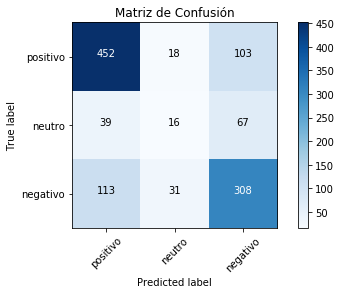


Matriz de confusión del modelo: Bernoulli Naive Bayes


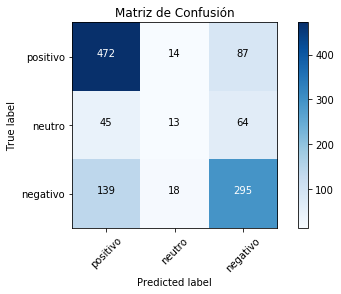


Matriz de confusión del modelo: Regresion Logistica


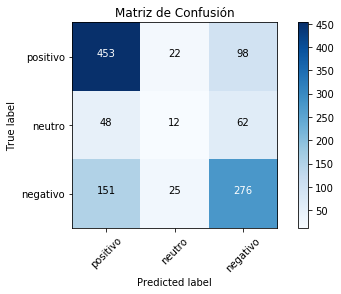


Matriz de confusión del modelo: Support Vector Machine


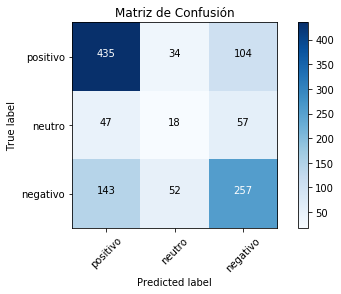


Matriz de confusión del modelo: Random Forest


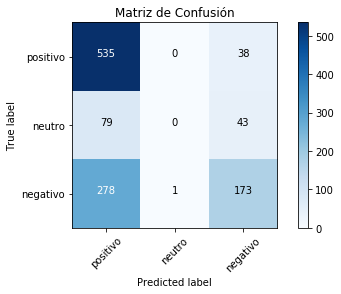

In [8]:
for model in evaluacion:
    print('\nMatriz de confusión del modelo: {name}'.format(name=model['name']))
    plt.figure()
    plot_confusion_matrix(model['confusion matrix'], classes=['positivo', 'neutro', 'negativo'], 
                          title='Matriz de Confusión')
    plt.show()